# Vignette for Cusanovich et al., 2017

This notebook will walk you through some of the analyses presented in Cusanovich et. al ([bioRxiv 2017](https://www.biorxiv.org/content/early/2017/07/20/166066)) for working with sci-ATAC-seq data from developing Drosophila melanogaster embryos. 
<br> This vignette is broken into the following sections:

1. Using latent semantic indexing ('LSI') to identify clades of cells with similar chromatin accessibility profiles ([jump to section](#usecase1))
1. Using t-SNE to identify finer-scale structure ([jump to section](#usecase2))
1. Identifying differentially accessible sites between clusters of cells ([jump to section](#usecase3))
1. Arranging cells along developmental trajectories with "pseudotemporal ordering" ([jump to section](#usecase4))

###Installation
###Required R Packages
-  Matrix
-  proxy
-  gplots
-  Rtsne
-  densityClust (from here https://github.com/Xiaojieqiu/densityClust)
-  DDRTree (version 0.1.4)
-  monocle (version 2.5.3)
-  irlba (version 1.0.3)

It is important that the correct version of monocle, DDRTree and irlba are installed. Other versions may produce different results. irlba v1.0.3 was used to generate the figures in the manuscript that are relevant to use cases 1 & 2, while monocle v2.5.3 and DDRTree are the versions that were used for the trajectories presented in the paper. For the first two use cases, we will install the legacy version of irlba (1.0.3) and for the second two we will detach irlba and then load monocle 2.5.3 and DDRTree 0.1.4. To install these packages, open a command line and run:

```
curl -O https://cran.r-project.org/src/contrib/Archive/irlba/irlba_1.0.3.tar.gz
mkdir ./old_irlba
R CMD INSTALL -l ./old_irlba irlba_1.0.3.tar.gz
curl -O http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/monocle_2.5.3.tar.gz
R CMD INSTALL monocle_2.5.3.tar.gz
curl -O https://cran.rstudio.com/src/contrib/Archive/DDRTree/DDRTree_0.1.4.tar.gz
R CMD INSTALL DDRTree_0.1.4.tar.gz
```


In [2]:
suppressPackageStartupMessages({
    library(Matrix)
    library(proxy)
    library(gplots)
    library(Rtsne)
    library(densityClust)
    library(irlba,lib.loc="./old_irlba/")
})

In [3]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.9 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] irlba_1.0.3      densityClust_0.3 Rtsne_0.13       gplots_3.0.1    
[5] proxy_0.4-16     Matrix_1.2-10   

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11        magrittr_1.5        uuid_0.1-2         
 [4] lattice_0.20-35     R6_2.2.2            stringr_1.2.0      
 [7] caTools_1.17.1      tools_3.2.1         grid_3.2.1         
[10] KernSmooth_2.23-15  gtools_3.5.0        dig

***
<a id="usecase1"></a>
## Use case 1: Using latent semantic indexing ('LSI') to identify clades of cells with similar chromatin accessibility profiles

We have found it convenient to store the data as a sparse, binary matrix of genomic loci x cells. Below we will walk you through an analysis where individual cells have been scored for insertions in 2kb windows throughout the genome. Note that if you want to go back to the raw sequencing data (FASTQ files), they are available at the Gene Expression Omnibus under accession code [GSE101581](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101581). We have made tools for manipulating these files available on [github](https://github.com/shendurelab/Fly-sciATAC). Alternatively, we have a great number of resources for interacting with the data at our companion [site](http://shiny.furlonglab.embl.de/scATACseqBrowser/).


First, we need to download the binary matrix and load it into R.

In [4]:
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/6to8.2kbmatrix.sparse.binary.rds",
    destfile = "6to8.2kbmatrix.sparse.binary.rds")
flies_6to8 = readRDS("6to8.2kbmatrix.sparse.binary.rds")

After filtering out 2kb windows that intersect with ENCODE-defined blacklist regions, we end up with 83,290 distinct 2kb windows in the drosophila genome and we have data from 7,880 cells at the 6-8 hour time point.

In [5]:
dim(flies_6to8)
flies_6to8[1:2,1:2]

[1] 83290  7880

2 x 2 sparse Matrix of class "dgCMatrix"
                AGCGATAGAACGAATTCGAGAACCGGAGCCTATCCT
chr2L_0_2000                                       .
chr2L_2000_4000                                    .
                AGCGATAGAACGAATTCGAGTCATAGCCGTACTGAC
chr2L_0_2000                                       .
chr2L_2000_4000                                    .

Let's collect some info about the frequency of insertion in individual windows and the variety of windows observed in individual cells. We can see that sites are observed in as many as 6,322 cells (80%), but are roughly normally distributed (with a long lower tail) on a log scale with a median of 330 cells having an insertion in each site.

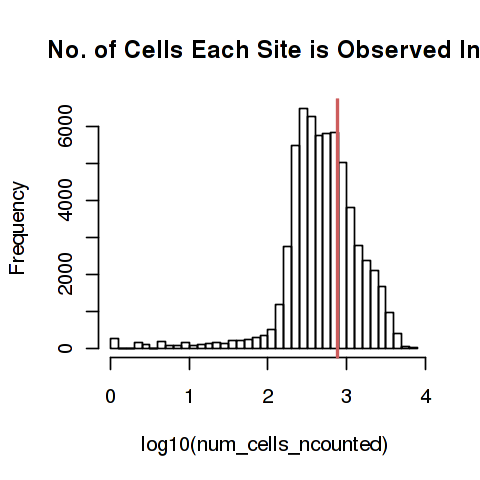

In [7]:
num_cells_ncounted = rowSums(flies_6to8)
options(repr.plot.width=4, repr.plot.height=4)
hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
abline(v=log10(num_cells_ncounted[order(num_cells_ncounted,decreasing=T)[20000]]),lwd=2,col="indianred")

Now let's only retain the most commonly used sites (top 20,000 here). Looking at the distribution of how many of these top 20,000 sites each cell covers, we can again see that the distribution is rougly log-normal (with a long lower tail) with a median of 3,751 windows covered by each cell.

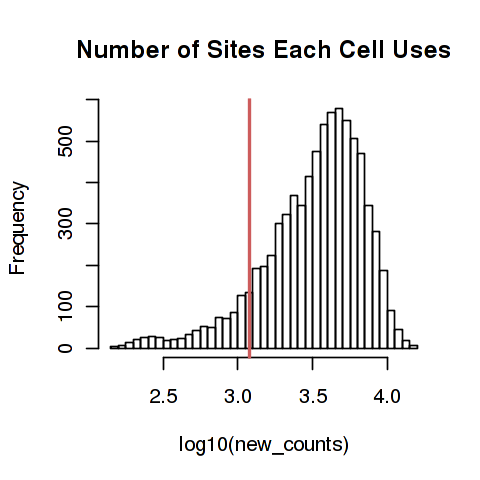

In [8]:
ncounts = flies_6to8[which(num_cells_ncounted >= num_cells_ncounted[order(num_cells_ncounted,decreasing=T)[20000]]),]
new_counts = colSums(ncounts)
hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
abline(v=log10(quantile(new_counts,probs=0.1)),lwd=2,col="indianred")

Before transforming the data, we just filter out the lowest 10% of cells (in terms of site coverage) and ensure that there are now empty sites.

In [9]:
ncounts = ncounts[,new_counts >= quantile(new_counts,probs=0.1)]
ncounts = ncounts[rowSums(ncounts) > 0,]

We can now transform the data using TF-IDF and then generate a lower dimensional representation of the data with truncated SVD (these are the two primary steps of LSI).

In [10]:
nfreqs = t(t(ncounts) / Matrix::colSums(ncounts))
idf = as(log(1 + ncol(ncounts) / Matrix::rowSums(ncounts)), "sparseVector")
tf_idf_counts = as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs

Here, we only retain components 2-6 (component 1 is highly correlated with read depth) and truncate the distribution of LSI values at +/-1.5.

In [11]:
#This step can take a minute
set.seed(0) #For reproducibility
SVD = irlba(tf_idf_counts, 6, 6)
sk_diag = matrix(0, nrow=6, ncol=6)
diag(sk_diag) = SVD$d
sk_diag[1,1] = 0

LSI_out = t(t(sk_diag %*% t(SVD$v)) %*% t(SVD$u))
LSI_out = t(scale(t(LSI_out)))
LSI_out[LSI_out > 1.5] = 1.5
LSI_out[LSI_out < -1.5] = -1.5

Next, we generate some info about the dendrograms that will be used for plotting the heatmap.

In [12]:
#This step can take a minute too
hclust_cells = hclust(proxy::dist(t(sk_diag %*% t(SVD$v)), method="cosine"), method="ward.D2")
hclust_genes = hclust(proxy::dist(t(sk_diag %*% t(SVD$u)), method="cosine"), method="ward.D2")

color_pal = c("#1F78B4","#FFD700","#60CC52","#E31A1C")
hmcols = colorpanel(100, "steelblue", "white", "tomato")
cells_tree_cut = cutree(hclust_cells, 4)
lsi_cells = cbind(colnames(ncounts),cells_tree_cut)

Finally, we can generate a bi-clustered heatmap showing how cells and sites are related.

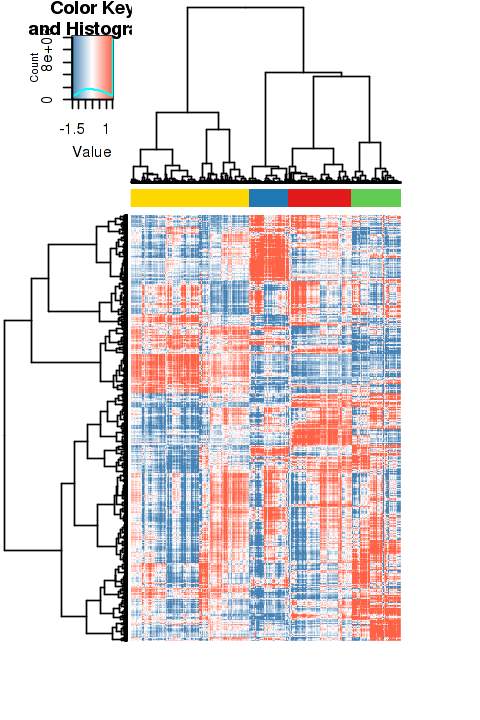

In [13]:
options(repr.plot.width=4, repr.plot.height=6)
heatmap.2(LSI_out, 
          col=hmcols,
          ColSideColors=color_pal[as.factor(cells_tree_cut)],
          #RowSideColors=color_pal[as.factor(genes_tree_cut)],
          Rowv = as.dendrogram(hclust_genes), Colv = as.dendrogram(hclust_cells),
          labRow=FALSE, labCol=FALSE, trace="none",  scale="none",
          useRaster=TRUE)

In [ ]:
rm(flies_6to8)
rm(ncounts)
rm(nfreqs)
rm(tf_idf_counts)
rm(SVD)
rm(LSI_out)

***
<a id="usecase2"></a>
## Use case 2: Using t-SNE to identify finer-scale structure

Having identified large clades of cells that were consistent with the development of germ layers during embryogenesis, we were able to identify peaks of chromatin accessibility in each clade after "_in silico_ sorting" the cells assigned to each cluster. We next sought to robustly identify smaller clusters of cells that might be more consistent with individual cell types so that we could learn about the individual regulatory elements that govern distinct cell states. To do so, we generated a master list of summits of accessibiity identified in each of the clades across the three time points and then created a matrix of sites by cells (similar to the last use case).


In [14]:
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/6to8.summitmatrix.sparse.binary.rds",
    destfile = "6to8.summitmatrix.sparse.binary.rds")
fly_summits_6to8 = readRDS("6to8.summitmatrix.sparse.binary.rds")
dim(fly_summits_6to8)
fly_summits_6to8[1:2,1:2]

[1] 53133  7880

2 x 2 sparse Matrix of class "dgCMatrix"
                AGCGATAGAACGAATTCGAGAACCGGAGCCTATCCT
chr2L_5543_5980                                    .
chr2L_6666_6881                                    .
                AGCGATAGAACGAATTCGAGTCATAGCCGTACTGAC
chr2L_5543_5980                                    .
chr2L_6666_6881                                    .

The analysis starts out similarly to the LSI example above. We first filter out sites that are seen in fewer cells (in this case we only keep sites that are seen in at least 5% of cells) and then cells that have relatively low coverage (again, we filter out the lowest 10% of cells).

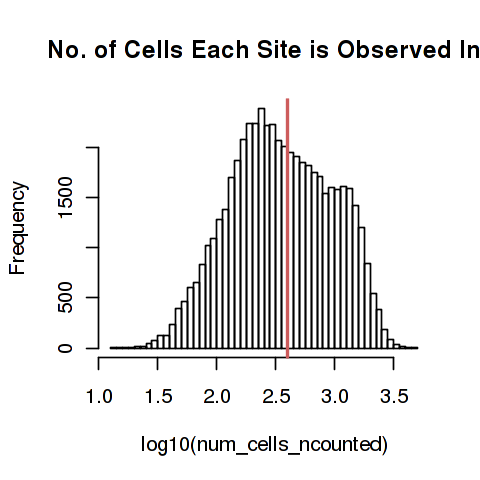

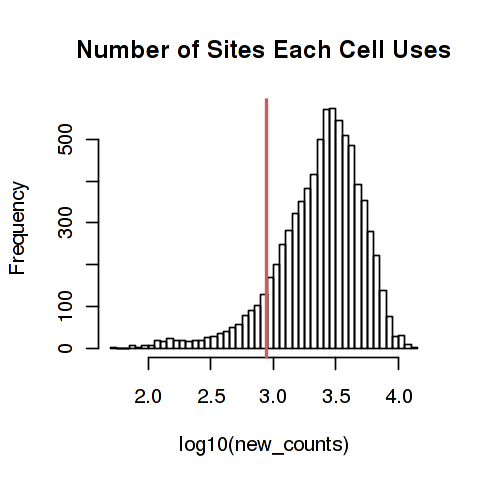

In [15]:
num_cells_ncounted = rowSums(fly_summits_6to8)
ncounts = fly_summits_6to8[num_cells_ncounted >= dim(fly_summits_6to8)[2]*0.05,]
new_counts = colSums(ncounts)
ncounts = ncounts[,new_counts >= quantile(new_counts,probs=0.1)]
ncounts = ncounts[rowSums(ncounts) > 0,]

options(repr.plot.width=4, repr.plot.height=4)
hist(log10(num_cells_ncounted),main="No. of Cells Each Site is Observed In",breaks=50)
abline(v=log10(min(num_cells_ncounted[num_cells_ncounted >= dim(fly_summits_6to8)[2]*0.05])),lwd=2,col="indianred")
hist(log10(new_counts),main="Number of Sites Each Cell Uses",breaks=50)
abline(v=log10(quantile(new_counts,probs=0.1)),lwd=2,col="indianred")

The next step is to tranform the data and generate a lower dimensional representation again, except that we first filter out sex chromosome counts. We also leave the first component in now, and we use 50 dimensions (rather than 6).

In [16]:
sexsites = c(grep("chrY",rownames(ncounts)),grep("chrX",rownames(ncounts)))
ncounts.nosex = ncounts[-sexsites,]

nfreqs = t(t(ncounts.nosex) / Matrix::colSums(ncounts.nosex))
idf = as(log(1 + ncol(ncounts.nosex) / Matrix::rowSums(ncounts.nosex)), "sparseVector")
tf_idf_counts = as(Diagonal(x=as.vector(idf)), "sparseMatrix") %*% nfreqs

set.seed(0)
SVDtsne = irlba(tf_idf_counts, 50, 50)
d_diagtsne = matrix(0, nrow=50, ncol=50)
diag(d_diagtsne) = SVDtsne$d
SVDtsne_vd = t(d_diagtsne %*% t(SVDtsne$v))

In [17]:
dim(ncounts.nosex)
ncounts.nosex[1:2,1:2]
tf_idf_counts[1:2,1:2]

[1] 19956  7092

2 x 2 sparse Matrix of class "dgCMatrix"
                AGCGATAGAACGAATTCGAGAACCGGAGCCTATCCT
chr2L_5543_5980                                    .
chr2L_7488_8077                                    .
                AGCGATAGAACGAATTCGAGTCATAGCCGTACTGAC
chr2L_5543_5980                                    .
chr2L_7488_8077                                    .

2 x 2 sparse Matrix of class "dgCMatrix"
                AGCGATAGAACGAATTCGAGAACCGGAGCCTATCCT
chr2L_5543_5980                                    .
chr2L_7488_8077                                    .
                AGCGATAGAACGAATTCGAGTCATAGCCGTACTGAC
chr2L_5543_5980                                    .
chr2L_7488_8077                                    .

Next, we use t-SNE to visualize the data. We feed this lower dimensional representation of the data directly into the Rtsne package.

In [18]:
set.seed(0)
tsnetfidf = Rtsne(SVDtsne_vd,pca=F)

To identify clusters of cells, we use the density peak algorithm.

In [19]:
tsnedist = dist(tsnetfidf$Y)
set.seed(0)
dclust = densityClust(tsnedist,gaussian=T)
dclust = findClusters(dclust, rho = 50, delta = 2.5)

Distance cutoff calculated to 3.405709 


the length of the distance: 25144686


The density peak algorithm requires you to set two parameters - "delta" and "rho". For each data point, the algorithm calculates a local density of other points within some set distance and the minimum distance to the next point that has a higher local density. On the basis of these two values, you can choose a set of points that are outliers both in local density and the distance to another point with a higher density, which become cluster "peaks". Below, we show you the distribution of these two values in our data set and where we decided to draw the cutoff. You can read more about this algorithm [here](http://science.sciencemag.org/content/344/6191/1492).

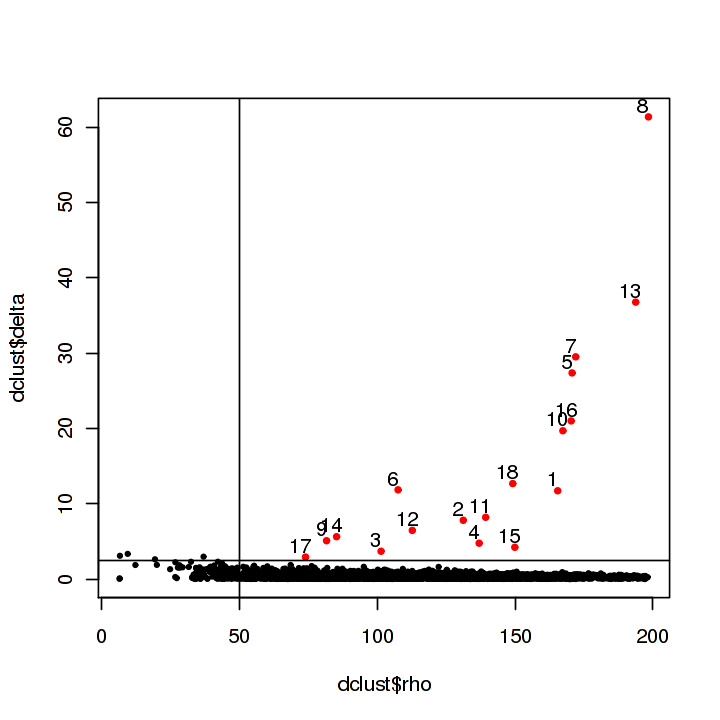

In [20]:
options(repr.plot.width=6, repr.plot.height=6)
plot(dclust$rho,dclust$delta,pch=20,cex=0.6)
points(dclust$rho[dclust$peaks],dclust$delta[dclust$peaks],col="red",pch=20,cex=0.8)
text(dclust$rho[dclust$peaks]-2,dclust$delta[dclust$peaks]+1.5,labels=dclust$clusters[dclust$peaks])
abline(v=50)
abline(h=2.5)

Finally, we plot the t-SNE plots and show how the points are related to our original LSI clustering, the assigned sex of each cell (you'll need to download an additional file for this), and curren density peak clusters.

In [21]:
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/6to8.xycalls.txt",
    destfile = "6to8.xycalls.txt")
sexcolors = read.table("6to8.xycalls.txt")

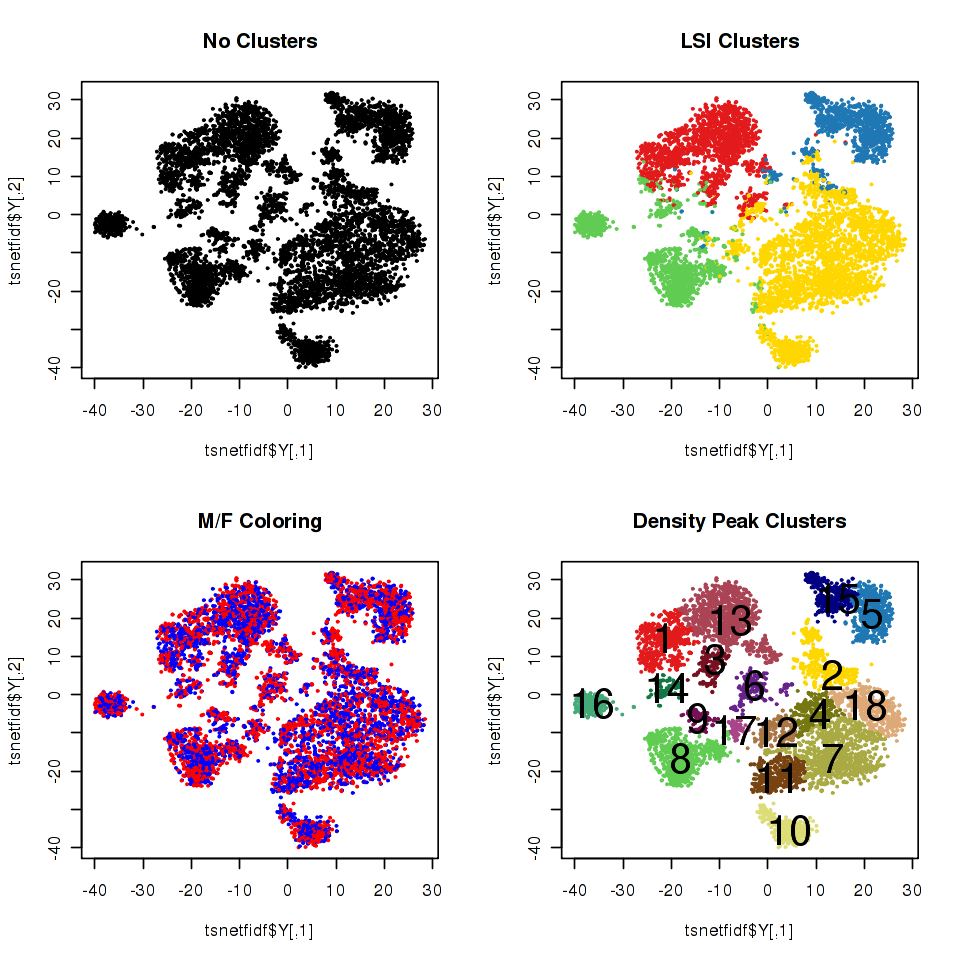

In [22]:
tsnecols = c("#E31A1C","#FFD700","#771122","#777711","#1F78B4","#68228B","#AAAA44",
             "#60CC52","#771155","#DDDD77","#774411","#AA7744","#AA4455","#117744",
             "#000080","#44AA77","#AA4488","#DDAA77")
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(2,2))
plot(tsnetfidf$Y,pch=20,main="No Clusters",cex=0.25)
plot(tsnetfidf$Y,pch=20,
     col=c("#1F78B4","#FFD700","#60CC52","#E31A1C")[as.factor(lsi_cells[match(colnames(tf_idf_counts),lsi_cells[,1]),2])],
     main="LSI Clusters",cex=0.25)
plot(tsnetfidf$Y,pch=20,col=c("blue","red")[sexcolors[match(colnames(tf_idf_counts),sexcolors[,1]),2]],
     main="M/F Coloring",cex=0.25)
plot(tsnetfidf$Y,pch=20,col=tsnecols[as.factor(dclust$clusters)],main="Density Peak Clusters",cex=0.25)
text(tsnetfidf$Y[dclust$peaks,1],tsnetfidf$Y[dclust$peaks,2],labels=dclust$clusters[dclust$peaks],cex=2.5)

In [ ]:
rm(fly_summits_6to8)
rm(ncounts)
rm(ncounts.nosex)
rm(nfreqs)
rm(tf_idf_counts)
rm(SVDtsne)
gc()

***
<a id="usecase3"></a>
## Use case 3: identifying differentially accessible sites between clusters of cells

Having defined clusters of cells on the basis of chromatin accessibility profiles, you might like to know which sites in the genome are different between clusters. To figure that out, we use the linear modelling framework implemented in Monocle. This use case will walk you through the steps to define which sites are open in mesodermal cells relative to all other cells in the time point, but the same framework could be applied to any comparison you like.

Before getting into the analysis, we need to take care of a few housekeeping things. First, we want to load Monocle to run the differential accessibility tests. To do this we detach the legacy version of irlba and then load Monocle. Finally, we created a little patch to Monocle that reports beta values from the differential accessibility tests so that we can distinguish sites that are opening from sites that are closing.

__NOTE:__ This code is implemented to run on multiple processors on a computing cluster, you may need special modifications to get this working in your preferred computing environment.

In [23]:
suppressPackageStartupMessages({
    detach("package:irlba", unload=TRUE)
    library(monocle)
})
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/monocle_patch.R",
    destfile = "monocle_patch.R")
source("monocle_patch.R")
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/6to8.read.report.txt",
    destfile = "6to8.read.report.txt")
readcounts = read.table("6to8.read.report.txt",header=T)

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::union’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::as_data_frame’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::groups’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::%>%’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘dplyr::add_rownames’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘dplyr::do’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘dplyr::group_by_’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘dplyr::inner_join’ when loading ‘monocle’”Warning message:
“replacing previous i

Because the summit matrix includes data for more cells, we first subset it cells that we have germ layer predictions for. We then filter out any sites that weren't observed in at least 50 cells.

In [25]:
goodcells = match(lsi_cells[,1],colnames(fly_summits_6to8))
da_mat = fly_summits_6to8[,goodcells]
num_cells_ncounted = rowSums(da_mat)
da_mat_final = da_mat[num_cells_ncounted >= 50,]

rm(da_mat)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1747068,93.4,11554252,617.1,14442815,771.4
Vcells,443259864,3381.9,2642652780,20161.9,3302654927,25197.3


We next want to load our site x cell matrix into a Cell Data Set ('CDS'), a format that allows us to use some of the convenience functions available in monocle. The first step is to set up a "phenotype" data frame. This is a framework for storing all kinds of information about individual cells.

In [27]:
readcounts.assigned = readcounts[match(lsi_cells[,1],rownames(readcounts)),]
clusterfactor = factor((lsi_cells[,2] == '4')+0,levels=c("0","1"))
pda = data.frame(as.character(lsi_cells[,1]),as.numeric(log10(readcounts.assigned[,2])),clusterfactor)
names(pda) = c("CellID", "ReadDepth","CellCluster")
pda = new("AnnotatedDataFrame", data = pda)

We next set up a "feature" data frame - a framework for storing information about data features (in this case, sites).

In [28]:
fda = as.data.frame(as.character(rownames(da_mat_final)))
names(fda) = "Peak"
fda = new("AnnotatedDataFrame", data = fda)

And then we can combine the feature data frame and phenotype data frame with the raw site x cell matrix into a CDS. Because the data are binary calls of insertions in sites, we set the `expressionFamily` to binomialff.

In [29]:
rownames(da_mat_final) = NULL
colnames(da_mat_final) = NULL
submat_cds =  newCellDataSet(da_mat_final,
        featureData = fda,
        phenoData = pda,
        expressionFamily=binomialff(),
        lowerDetectionLimit=1)

pData(submat_cds)$Size_Factor = 1

Warning message in newCellDataSet(da_mat_final, featureData = fda, phenoData = pda, :
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(da_mat_final, featureData = fda, phenoData = pda, :
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(da_mat_final, featureData = fda, phenoData = pda, :
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”

Here we just delete some variables that we won't need anymore to free up RAM.

In [30]:
rm(readcounts.assigned)
rm(fda)
rm(pda)
rm(da_mat_final)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1810190,96.7,9243401,493.7,14442815,771.4
Vcells,443430760,3383.2,2114122224,16129.5,3302654927,25197.3


And now we're ready to run the likelihood ratio tests to identify differentially accessible sites. Monocle provides a convenient wrapper for doing this with the `differentialGeneTest` function. This step can take several minutes to run.

In [31]:
differtest = differentialGeneTest(submat_cds, fullModelFormulaStr = "~CellCluster + ReadDepth",
                                   reducedModelFormulaStr = "~ReadDepth", cores=15)
head(differtest[order(differtest$qval),])

Warning message:
“closing unused connection 18 (<-localhost:11614)”Warning message:
“closing unused connection 17 (<-localhost:11614)”Warning message:
“closing unused connection 16 (<-localhost:11614)”Warning message:
“closing unused connection 15 (<-localhost:11614)”Warning message:
“closing unused connection 14 (<-localhost:11614)”Warning message:
“closing unused connection 13 (<-localhost:11614)”Warning message:
“closing unused connection 12 (<-localhost:11614)”Warning message:
“closing unused connection 11 (<-localhost:11614)”Warning message:
“closing unused connection 10 (<-localhost:11614)”Warning message:
“closing unused connection 9 (<-localhost:11614)”Warning message:
“closing unused connection 8 (<-localhost:11614)”Warning message:
“closing unused connection 7 (<-localhost:11614)”Warning message:
“closing unused connection 6 (<-localhost:11614)”Warning message:
“closing unused connection 5 (<-localhost:11614)”Warning message:
“closing unused connection 4 (<-localhost:11614)”

,status,family,pval,beta,qval,Peak
24326,OK,binomialff,0.000000e+00,2.778820,0.000000e+00,chr3L_10547945_10548368
38943,OK,binomialff,0.000000e+00,3.194512,0.000000e+00,chr3R_18852360_18852769
8709,OK,binomialff,0.000000e+00,3.442576,0.000000e+00,chr2L_20476729_20477328
8716,OK,binomialff,1.388543e-311,3.344137,1.809584e-307,chr2L_20486338_20486627
12015,OK,binomialff,1.716059e-305,3.306066,1.789129e-301,chr2R_5822850_5823121
19994,OK,binomialff,4.726260e-298,2.672527,4.106254e-294,chr3L_589563_589900


With this test, we find 19,535 sites are differentially accessible (1% FDR) in myogenic mesoderm cells relative to all other cells in the embryo. 8,398 of these are more accessible in myogenic mesoderm than other cells, while 11,137 are less accessible in myogenic mesoderm. We can see that the sites in the top of the list are consistent with what you'd expect (for example, the second most significant hit happens to be the promoter of _[lmd](http://genome.ucsc.edu/cgi-bin/hgTracks?db=dm3&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr3R%3A18852361-18852769&hgsid=643680341_WUtTSN0POZLME0gO3LWuI5A5OXJi)_, a known master regulator of "[fusion-competent myoblasts](http://www.sdbonline.org/sites/fly/gene/lamedk1.htm)".

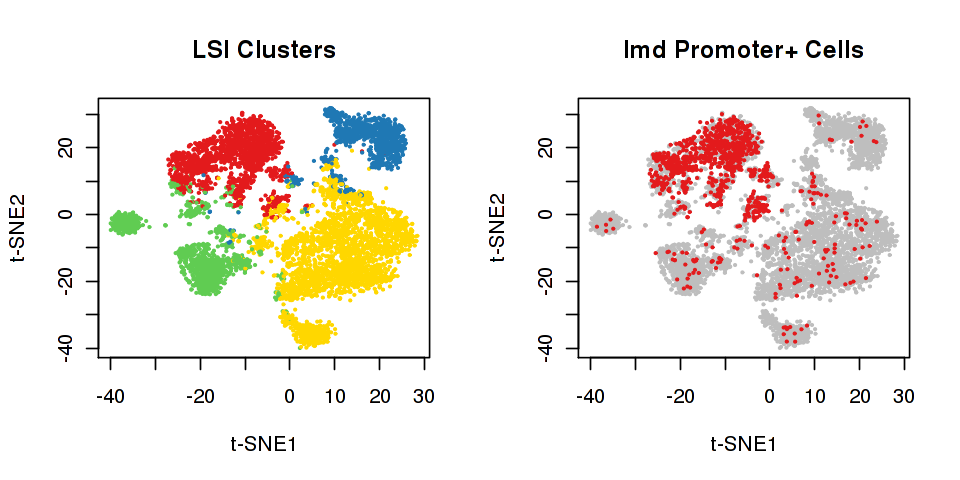

In [32]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(tsnetfidf$Y,pch=20,
     col=c("#1F78B4", "#FFD700", "#60CC52", "#E31A1C")[as.factor(lsi_cells[match(colnames(tf_idf_counts),
     lsi_cells[,1]),2])],main="LSI Clusters",cex=0.25,xlab="t-SNE1",ylab="t-SNE2")
plot(tsnetfidf$Y[match(pData(submat_cds)$CellID,colnames(tf_idf_counts)),][order(exprs(submat_cds)[38943,]),],pch=20,
     main="lmd Promoter+ Cells",cex=0.25,
     col=ifelse(exprs(submat_cds)[38943,][order(exprs(submat_cds)[38943,])] > 0,"#E31A1C","gray"),
     xlab="t-SNE1",ylab="t-SNE2")

In [ ]:
rm(da_mat_final)
rm(submat_cds)
gc()

***
<a id="usecase4"></a>
## Use case 4: Arranging cells along developmental trajectories with "pseudotemporal ordering"
One very powerful aspect of single-cell technologies is that we can use them to trace the developmental trajectories of cells. In the Cusanovich et al. paper, we showed that sci-ATAC-seq data can be used to identify developmental trajectories. Here we walk you through the basic steps of that analysis.

For this analysis, we turn to the 2-4 hour time point, so we'll load a cds for cells from that time point. On the basis of the t-SNE analysis of these cells we were able to classify the cells into the following 7 cell types: 'Unknown', 'Collisions', 'Blastoderm', 'Neural', 'Ectoderm',  'Mesoderm', 'Endoderm'. However, we really wanted to see how cells transitioned from the blastoderm state to the germ layers, so we used monocle to arrange cells in a progression to learn about how the regulatory landscape of the genome changed through development.

One note: instead of using the counts of reads mapping to individual sites of accessibility for this analysis, we binned all the sites that were near eachother in order to improve the sparsity of the data.

To run through this section, we need several files, so we'll download a tarball and unpack it before proceeding.

In [33]:
download.file(
    "http://krishna.gs.washington.edu/content/members/cusanovich/fly_embryogenesis/updated_data/vignette/2to4_files.tar.gz",
    destfile = "2to4_files.tar.gz")
system("tar -xzf 2to4_files.tar.gz")
cds_2to4 = readRDS("./2to4_files/cds_2to4_aggregated.rds")
overlapped_sites = read.table('./2to4_files/2to4.overlapped_sites.bed')
cell_classification = read.table('./2to4_files/2to4.germlayers.txt')
table(cell_classification$V2)


Blastoderm Collisions   Ectoderm   Endoderm   Mesoderm     Neural    Unknown 
      2662        164       1865        575       1496        103        358 

After unpacking all those files, we want to collect the top 100 DA sites for each of the cell types found in this time point (excluding sites from the 'Collisions' and 'Unknown' categories). After collecting those sites we need to determine which binned sites they overlap.

In [34]:
DA_monocle_list = lapply(seq(1,7,1), FUN = function(x) {
    DA_file_name = paste0('./2to4_files/2to4.sigopen.cluster', x, '.txt')
    DA_file = read.csv(DA_file_name, sep = '\t', header = F)
    DA_file$GL = x
    return (DA_file)
})

DA_monocle = data.table::rbindlist(DA_monocle_list)
colnames(DA_monocle) = c('chr','start', 'end', 'qvalue', 'GL')
DA_monocle$coord = paste(DA_monocle$chr, DA_monocle$start, DA_monocle$end, sep = '_')

get_top_DA = function(cluster = 1, DA_results=DA_GL, num = 500){
    DA_this_cluster = subset(DA_results, GL == cluster)
    DA_this_cluster = DA_this_cluster[order(DA_this_cluster[,qvalue]),]
    if (num > nrow(DA_this_cluster)){
        return (DA_this_cluster[c(1:nrow(DA_this_cluster)),]$coord)
    }else {return (DA_this_cluster[c(1:num),]$coord)}
}

DA_sites_to_order = unlist(lapply(c(1,3,4,5,6), get_top_DA, DA_results = DA_monocle,num=100))
overlapped_DA_sites_to_order = subset(overlapped_sites, V4 %in% DA_sites_to_order)$V8

We then update the 2-4 hour CDS to track what the germ layer assingments are and to establish which sites should be used for ordering cells (the top DA sites we defined above).

In [35]:
rownames(cell_classification) = cell_classification$V1
germ_layer_pallet = c('Unknown'='#68228B', 'Blastoderm'='#808080', 'Neural'='#1F78B4', 'Ectoderm'='#FFD700',
                      'Mesoderm'= '#E31A1C', 'Endoderm'='#60CC52', 'Collisions'='saddlebrown')
cell_classification = cell_classification[rownames(pData(cds_2to4)),]
cds_2to4$germ_layer_name = cell_classification$V2
fData(cds_2to4)$use_for_ordering = FALSE
cds_2to4 = setOrderingFilter(cds_2to4, overlapped_DA_sites_to_order)

Having set up the CDS, now we use `DDRTree` to learn the developmental trajectory and then arrange cells on that trajectory with the `oderCells` function.

In [37]:
cds_2to4 = reduceDimension(cds_2to4,reduction_method="DDRTree",
                                    ncenter=200,
                                    max_components = 3,
                                    maxIter=1000,
                                    auto_param_selection = FALSE,
                                    residualModelFormulaStr="~as.numeric(num_genes_expressed)",
                                    )

cds_2to4 = orderCells(cds_2to4)

In [38]:
#This is just a convenience function for plotting to figures side-by-side, since ggplot2 can't do that by default.
#from http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }
 if (numPlots==1) {
    print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

Now we can plot the cells on the trajectory to evaluate how the trajectory relates to our germ layer assignments. Please note that either of the axes may be flipped for you which will affect where monocle puts the root state. With the set of parameters we've chosen, you can see that at the beginning of pseudotime all the cells are following a single trajectory and most of the cells here are from the "Blastoderm" clusters. However, as pseudotime progresses, we get three branches - each primarily made up of cells from one of the three major germ layers observed at this time point.

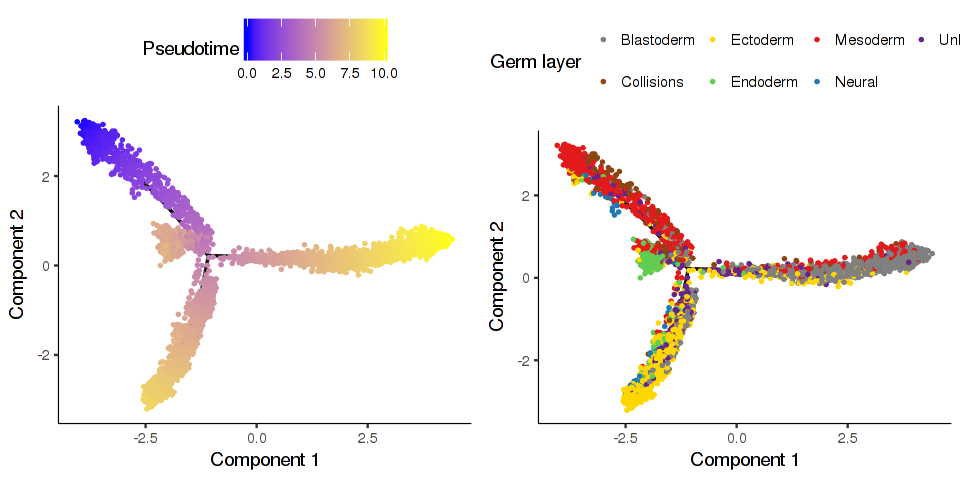

In [39]:
options(repr.plot.width=8, repr.plot.height=4)
p1 = plot_cell_trajectory(cds_2to4, 1, 2, color_by = 'Pseudotime', show_branch_points = F, cell_size = 0.5) +
    scale_colour_gradient2(name = 'Pseudotime', mid='blue', high = 'yellow')
p2 = plot_cell_trajectory(cds_2to4, 1,2, color_by = 'germ_layer_name', show_branch_points = F, cell_size = 0.5) +
       scale_color_manual(values = germ_layer_pallet) + labs (color = 'Germ layer')
multiplot(p1,p2,cols=2)

For more examples of analyses that you can do with monocle, please visit the monocle [website](http://cole-trapnell-lab.github.io/monocle-release/docs_mobile/). If you'd like to interact with the processed data and check out browser tracks for the clusters of cells we've identified, please visit our companion [site](http://shiny.furlonglab.embl.de/scATACseqBrowser/). Finally, if you'd like, you can download the raw data [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101581), and we've also made the code we used to process the raw data available on [github](https://github.com/shendurelab/Fly-sciATAC).

In [40]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.9 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      splines   stats4    parallel  stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] monocle_2.5.3       DDRTree_0.1.4       irlba_2.2.1        
 [4] VGAM_1.0-3          ggplot2_2.2.1       Biobase_2.30.0     
 [7] BiocGenerics_0.16.1 densityClust_0.3    Rtsne_0.13         
[10] gplots_3.0.1        proxy_0.4-16        Matrix_1.2-10      

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           lattice_0.20-35    